# 3.0 Pre-processing and Training

Contents

3.1 [Introduction](#3.1)

  * [3.1.1 Problem Recap](#3.1.1)
  * [3.1.2 Notebook Goals](#3.1.2)
 
3.2 [Load the data](#3.2)

  * [3.2.1 Imports](#3.2.1)
  * [3.2.2 Load the data](#3.2.2)

3.3 [Examine Class Split](#3.3)

3.4 [Pre-processing](#3.4)

  * [3.4.1 Set Random Seed for Reproducability](#3.4.1)
  * [3.4.2 Train/test Split](#3.4.2)
  * [3.4.3 Examine Class Split for Train/Test Data](#3.4.3)
  

3.5 [Vectorizing the Text](#3.5)

  * [3.5.1 Count Vectorization](#3.5.1)
  * [3.5.2 Term-Frequency Inverse-Document Frequency](#3.5.2)

3.6 [Building some Simple Models](#3.6)
  * 3.6.1 [Logistic Regression](#3.6.1)
<br/><br/>
    * [3.6.1.1 Training the Model](#3.6.1.1)
    * [3.6.1.2 Fitting the Model](#3.6.1.2)
    * [3.6.1.3 Evaluating the Model](#3.6.1.3)
<br/><br/>
  * 3.6.2 [Naive Bayes](#3.6.2)
<br/> <br/> 
    * [3.6.2.1 Training the Model](#3.6.1.1)
    * [3.6.2.2 Fitting the Model](#3.6.2.2)
    * [3.6.2.3 Evaluating the Model](#3.6.2.3)
<br/> <br/>
  * 3.6.3 [Random Forest Classifier](#3.6.3)
<br/>  <br/>
    * [3.6.3.1 Training the Model](#3.6.3.1)
    * [3.6.3.2 Fitting the Model](#3.6.3.2)
    * [3.6.3.3 Evaluating the Model](#3.6.3.3)



## 3.1 Introduction <a name="3.1"></a>

### 3.1.1 Problem Recap <a name="3.1.1"><a/>

Using customer text data about amazon products, we will build, evaluate and compare models to estimate the probability that a given text review can be classified as “positive” or “negative”.

Our goal is to build a text classifier using Amazon product review data which can be used to analyze customer sentiment which does not have accompanying numeric data.

### 3.1.2 Notebook Goals <a name="3.1.2"></a>

1. Examine the split between the class we're trying to predict.

2. Split the data into train and test sets.

3. Convert our text review data into numeric features. (CountVectorization, TFIDF, and word2vec are options)

4. Build a few simple, initial predictive models.

5. Logistic Regression predicts probabilities. With "positive" (0) and "negative" (1) review, we can do a binary classification.

6. Measure the performance of the model with a Classification Report, Confusion Matrix and ROC + AUC.

## 3.2 Load the data <a name="3.2"><a/>

### 3.2.1 Imports <a name="3.2.1"><a/>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import train_test_split
from random import seed
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier

### 3.2.2 Load the data <a name="3.2.2"><a/>

In [2]:
data = pq.read_table("../data/edited/fashion.parquet")
fashion = data.to_pandas()

In [3]:
fashion.head()

,review,neg_sentiment,stars,review_length
0,exactly needed,0,5,4
1,agree review opening small bent hook expensiv...,1,2,49
2,love going order pack work including losing ea...,0,4,50
3,tiny opening,1,2,4
4,okay,1,3,1


In [4]:
fashion.describe()

,neg_sentiment,stars,review_length
count,873352.000000,873352.000000,873352.000000
mean,0.304939,3.904786,29.131591
std,0.460382,1.419361,39.372047
min,0.000000,1.000000,1.000000
25%,0.000000,3.000000,7.000000
50%,0.000000,5.000000,17.000000
75%,1.000000,5.000000,36.000000
max,1.000000,5.000000,2196.000000


In [5]:
fashion.shape

(873352, 4)

## 3.3 Examine Class Split <a name="3.3"><a/>

In [6]:
def plot_sentiment_split(df_col:pd.Series):

    df_col.value_counts().plot(kind="pie")
    plt.legend(labels=("Positive Reviews","Negative Reviews"))
    plt.title("Review Sentiment Split")
    plt.show()

    positive, negative = df_col.value_counts(normalize=True).values

    pos_perc = round(positive * 100, 2)
    neg_perc = round(negative * 100, 2)
    print(f"Positive reviews: {pos_perc}%\n", f"Negative reviews: {neg_perc}%")

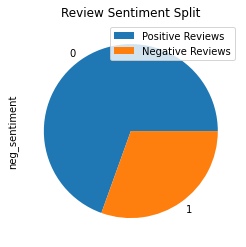

Positive reviews: 69.51%
 Negative reviews: 30.49%


In [7]:
plot_sentiment_split(fashion["neg_sentiment"])

We have more than double the positive reviews vs. negative reviews. The class we are trying to predict is negative reviews which are coded as "1".

## 3.4 Pre-Processing <a name="3.4"><a/>

### 3.4.1 Set Random Seed for Reproducability <a name="3.4.1"><a/>

In [8]:
seed(42)

### 3.4.2 Train/Test Split <a name="3.4.2"><a/>

In [9]:
#split into train and test with a 90% / 10% ratio

X_train, X_test, y_train, y_test = train_test_split(fashion["review"].values, fashion["neg_sentiment"], test_size = .1)

### 3.4.3 Examine Class Split for Train/Test Data <a name="3.4.3"><a/>

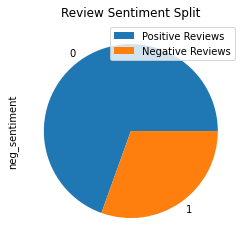

Positive reviews: 69.52%
 Negative reviews: 30.48%


In [10]:
plot_sentiment_split(y_train)

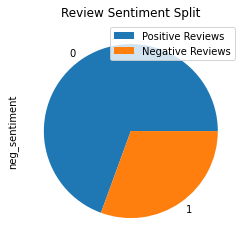

Positive reviews: 69.42%
 Negative reviews: 30.58%


In [11]:
plot_sentiment_split(y_test)

The train-test split is very representative of the split of the entire dataset (roughly .1 percent difference).

In [12]:
#convert to 1d arrays for modeling
y_train, y_test = np.ravel(y_train), np.ravel(y_test)

## 3.5 Vectorizing and Training <a name="3.5"><a/>

### 3.5.1 Logistic Regression with Count Vectorization

In [13]:
#Trying a logistic model with simple bag-of-words Count Vectorization

#instantiate tfidf using a max_df to eliminate the most common words (uni-gram and bi-grams) in 90%+ of reviews
count_vec = CountVectorizer()

#fit the vectorizer on the training data
count_vec.fit(X_train)

#transform both the training and test data
X_train_vec = count_vec.transform(X_train)
X_test_vec = count_vec.transform(X_test)



print(X_train_vec.shape, type(X_train_vec), X_test.shape)
print(y_train.shape, y_test.shape)

#Using the sklearn StandardScaler to normalize the data, with a "with_mean" parameter for sparse matrices
scaler = StandardScaler(with_mean=False)

#fit on the training data, scale both train and text
X_train_vec = scaler.fit_transform(X_train_vec)
X_test_vec = scaler.transform(X_test_vec)

#using the default solver
lr = LogisticRegression(solver = "lbfgs", n_jobs=-1, max_iter=500)

#train the lr model with the training data
lr.fit(X_train_vec, y_train)

#predict on the training data
train_preds = lr.predict(X_train_vec)


#predict on the test data
test_preds = lr.predict(X_test_vec)


(786016, 75238) <class 'scipy.sparse.csr.csr_matrix'> (87336,)
(786016,) (87336,)


### Count Vectorized-Linear Regression Train Set Results

In [14]:
print(classification_report(y_train, train_preds))



              precision    recall  f1-score   support

           0       0.92      0.95      0.93    546402
           1       0.87      0.81      0.84    239614

    accuracy                           0.90    786016
   macro avg       0.89      0.88      0.88    786016
weighted avg       0.90      0.90      0.90    786016



### Count Vectorized-Linear Regression Test Set Results

In [15]:
results_dict = {}

              precision    recall  f1-score   support

           0       0.90      0.93      0.91     60631
           1       0.82      0.76      0.79     26705

    accuracy                           0.88     87336
   macro avg       0.86      0.84      0.85     87336
weighted avg       0.87      0.88      0.87     87336

Confusion matrix values: 
[[56128  4503]
 [ 6340 20365]]


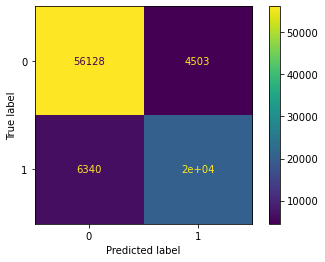

In [16]:
print(classification_report(y_test, test_preds))

results_dict["Log. Reg. Count Vec"] = classification_report(y_test, test_preds)


print(f"Confusion matrix values: \n{confusion_matrix(y_test, test_preds)}")
ConfusionMatrixDisplay.from_predictions(y_test, test_preds)

plt.show()


### Our first Logistic regression model has fairly good metrics on our majority class (0) but worse on the minority class (1) that we really care about predicting. 

Recall  =  True Positives / (True Positives + False Negatives)

Our recall is only .76 on the test set for the positive class. We are predicting 20190 of our positives data points correctly vs 6445 of them incorrectly. We'll try using TF-IDF vectorization instead and see if that impoves our results. 

### 3.5.2 Logistic Regression with Term-Frequency Inverse Document Frequency Vectorization

In [17]:
#Trying a logistic model with Tfidf Vectorization

#instantiate tfidf using a max_df to eliminate the most common words (uni-gram and bi-grams) in 90%+ of reviews
tfidf = TfidfVectorizer(ngram_range=(1,2), max_df=0.9)

#fit the vectorizer on the training data
tfidf.fit(X_train)

#transform both the training and test data
X_train_vec = tfidf.transform(X_train)
X_test_vec = tfidf.transform(X_test)

print(X_train_vec.shape, X_test.shape)
print(y_train.shape, y_test.shape)

#using the default solver
lr = LogisticRegression(solver = "lbfgs", n_jobs=-1, max_iter=500)

#train the lr model with the training data
lr.fit(X_train_vec, y_train)

#predict on the training data
train_preds = lr.predict(X_train_vec)

#predict on the test data
test_preds = lr.predict(X_test_vec)


(786016, 2311690) (87336,)
(786016,) (87336,)


### Tfidf-Logistic Regression Training set results

In [18]:
print(classification_report(y_train, train_preds))

print(f"Confusion matrix values: \n{confusion_matrix(y_train, train_preds)}")


              precision    recall  f1-score   support

           0       0.93      0.96      0.95    546402
           1       0.90      0.85      0.87    239614

    accuracy                           0.92    786016
   macro avg       0.92      0.90      0.91    786016
weighted avg       0.92      0.92      0.92    786016

Confusion matrix values: 
[[523930  22472]
 [ 36904 202710]]


### Tfidf-Logistic Regression Test Set Results

              precision    recall  f1-score   support

           0       0.92      0.94      0.93     60631
           1       0.86      0.80      0.83     26705

    accuracy                           0.90     87336
   macro avg       0.89      0.87      0.88     87336
weighted avg       0.90      0.90      0.90     87336

Confusion matrix values: 
[[57103  3528]
 [ 5281 21424]]


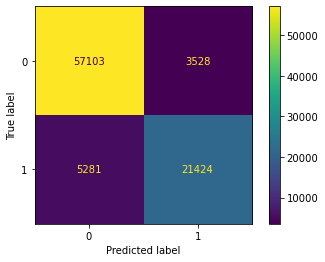

In [19]:
print(classification_report(y_test, test_preds))

results_dict["Log. Reg. TFIDF"] = classification_report(y_test, test_preds)


print(f"Confusion matrix values: \n{confusion_matrix(y_test, test_preds)}")
ConfusionMatrixDisplay.from_predictions(y_test, test_preds)

plt.show()



### Logistic regression with TFIDF vectorization has better metrics than with Count Vectorization 

Recall  =  True Positives / (True Positives + False Negatives)

Our recall is only .81 (vs .76 for Count Vec.) on the test set for the positive class. We are predicting 21560 of our positives data points correctly vs 5214 of them incorrectly. Though we don't care quite as much about the negative class, our metrics for it are also better than the LR model with Count Vectorization.

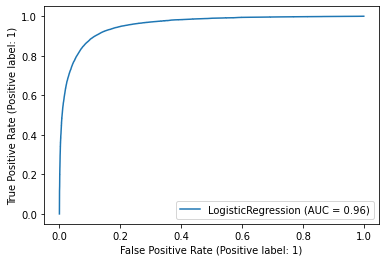

In [20]:
RocCurveDisplay.from_estimator(lr, X_test_vec, y_test)


Examining the ROC curve we see a very high AUC (.95). The curve is showing the TPR vs FPR for each possible cut-off for the probabilities output by the Logistic Regression model. The model gives a probability for a positive or negative prediction for each individual data point and then chooses the best cutoff. The curve shows how this varies across a range of different cut offs from 0-1.

## 3.5.4 Naive Bayes with Count Vectorization

In [21]:
#Trying a Naive Bayesian model with simple bag-of-words Count Vectorization

#instantiate tfidf using a max_df to eliminate the most common words (uni-gram and bi-grams) in 90%+ of reviews
count_vec = CountVectorizer()

#fit the vectorizer on the training data
count_vec.fit(X_train)

#transform both the training and test data
X_train_vec = count_vec.transform(X_train)
X_test_vec = count_vec.transform(X_test)

print(X_train_vec.shape, type(X_train_vec), X_test.shape)
print(y_train.shape, y_test.shape)

#Using the sklearn StandardScaler to normalize the data, with a "with_mean" parameter for sparse matrices
scaler = StandardScaler(with_mean=False)

#fit on the training data, scale both train and text
X_train_vec = scaler.fit_transform(X_train_vec)
X_test_vec = scaler.transform(X_test_vec)

#using the default solver
comp_nb = ComplementNB()

#train the lr model with the training data
comp_nb.fit(X_train_vec, y_train)

#predict on the training data
train_preds = comp_nb.predict(X_train_vec)

#predict on the test data
test_preds = comp_nb.predict(X_test_vec)


(786016, 75238) <class 'scipy.sparse.csr.csr_matrix'> (87336,)
(786016,) (87336,)


### Naive Bayes Train Set Results

In [22]:
print(classification_report(y_train, train_preds))

              precision    recall  f1-score   support

           0       0.92      0.82      0.87    546402
           1       0.67      0.85      0.75    239614

    accuracy                           0.83    786016
   macro avg       0.80      0.83      0.81    786016
weighted avg       0.85      0.83      0.83    786016



### Naive Bayes Test Set Results 

              precision    recall  f1-score   support

           0       0.90      0.80      0.85     60631
           1       0.64      0.81      0.72     26705

    accuracy                           0.80     87336
   macro avg       0.77      0.81      0.78     87336
weighted avg       0.82      0.80      0.81     87336

Confusion matrix values: 
[[48616 12015]
 [ 5110 21595]]


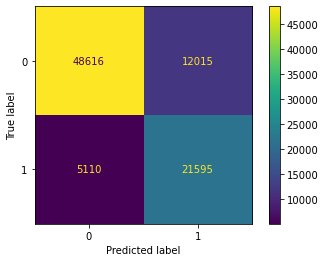

In [23]:
print(classification_report(y_test, test_preds))

results_dict["Naive Bayes Count Vec"] = classification_report(y_test, test_preds)


print(f"Confusion matrix values: \n{confusion_matrix(y_test, test_preds)}")
ConfusionMatrixDisplay.from_predictions(y_test, test_preds)

plt.show()



### Naive Bayes Results:

The Naive Bayes model is giving a fairly good recall of .80 on the positive class we are predicting, but interestingly predicts a much higher number of the negative class incorrectly (notice the low precision).

Precision  =  True Positives / True Positives + False Positives


In [24]:
precision = 21624 / (21624 + 12062)

print(f"Precision of our Naive Bayes model: \t{precision}")

Precision of our Naive Bayes model: 	0.64192839755388


### Random Forest Classifier with Count Vectorizations

In [25]:
#Trying a Random Forest model with simple bag-of-words Count Vectorization

#instantiate tfidf using a max_df to eliminate the most common words (uni-gram and bi-grams) in 90%+ of reviews
count_vec = CountVectorizer()

#fit the vectorizer on the training data
count_vec.fit(X_train)

#transform both the training and test data
X_train_vec = count_vec.transform(X_train)
X_test_vec = count_vec.transform(X_test)

print(X_train_vec.shape, type(X_train_vec), X_test.shape)
print(y_train.shape, y_test.shape)

#Since Random Forest models use linear decision boundaries, it should not need scaled input data

#using the default solver
rfc = RandomForestClassifier(max_leaf_nodes=1000, min_samples_leaf=5)

#train the lr model with the training data
rfc.fit(X_train_vec, y_train)

#predict on the training data
train_preds = rfc.predict(X_train_vec)


#predict on the test data
test_preds = rfc.predict(X_test_vec)


(786016, 75238) <class 'scipy.sparse.csr.csr_matrix'> (87336,)
(786016,) (87336,)


              precision    recall  f1-score   support

           0       0.83      0.97      0.90     60631
           1       0.90      0.56      0.69     26705

    accuracy                           0.85     87336
   macro avg       0.87      0.77      0.80     87336
weighted avg       0.85      0.85      0.84     87336

Confusion matrix values: 
[[58977  1654]
 [11691 15014]]


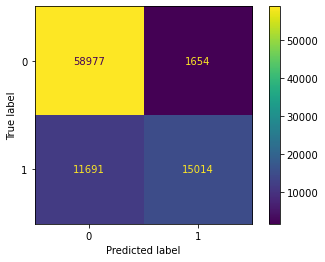

In [26]:
print(classification_report(y_test, test_preds))

results_dict["Random Forest Count Vec."] = classification_report(y_test, test_preds)


print(f"Confusion matrix values: \n{confusion_matrix(y_test, test_preds)}")
ConfusionMatrixDisplay.from_predictions(y_test, test_preds)

plt.show()


### Random Forest w/Count Vectorizer Results:
It seems like this model is STONGLY overfitting our training data. The recall on the test set for our positive class (1) is only .57 which is very poor. We are seeing a very high number of False Negatives (11573) which will results in the poor recall for our positive class.